In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/Pickleapp/224x224_sized')

In [ ]:
X_train = np.load("train_X.npy")
y_train = np.load("train_y.npy")
X_test = np.load("test_X.npy")
y_test = np.load("test_y.npy")
X_test_noaug = np.load("noaug_test_X.npy")
y_test_noaug = np.load("noaug_test_y.npy")
right_X_train = np.load("right_orient_train_X.npy")
right_y_train = np.load("right_orient_train_y.npy")
right_X_test = np.load("right_orient_test_X.npy")
right_y_test = np.load("right_orient_test_y.npy")


In [ ]:
shape = (224, 224, 3)
points = [1,2,3,4,5,6]
# points = [1]
point_cols = [(2 * (p-1), 2 * (p-1) + 1) for p in points]
point_cols = np.array(point_cols).flatten()
num_points = len(points) * 2

y_train = y_train[:, point_cols]
y_test = y_test[:, point_cols]
y_test_noaug = y_test_noaug[:, point_cols]
right_y_train = right_y_train[:, point_cols]
right_y_test = right_y_test[:, point_cols]


In [ ]:
bm = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
)
bm.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=shape)
x = bm(inputs, training=False)
# x.trainable = False
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_points, activation = 'relu')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 28224)             0         
                                                                 
 dropout_4 (Dropout)         (None, 28224)             0         
                                                                 
 dense_4 (Dense)             (None, 12)                338700    
                                                                 
Total params: 1277820 (4.87 MB)
Trainable params: 338700 (1.29 MB)
Non-trainable params: 939120 (3.58 MB)
___________________

In [ ]:
def average_distance_loss(y_true, y_pred):
    """
    Custom loss function to calculate the average distance between predicted and target coordinates for 6 points.

    Parameters:
    - y_true: Tensor of shape (batch_size, 12), representing the target coordinates.
    - y_pred: Tensor of shape (batch_size, 12), representing the predicted coordinates.

    Returns:
    - loss: Tensor representing the average distance loss.
    """
    # Reshape the tensors to (batch_size, 6, 2) for easy indexing of coordinates
    # print(y_true)
    # print(y_pred)
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))

    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    # print(distances)
    # Calculate the average distance across all coordinates and batches
    loss = tf.reduce_mean(distances)

    return loss

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=average_distance_loss,
                metrics=['mae'])

In [ ]:
print(len(X_train), len(X_test))

1428 372


In [ ]:
callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights = True)
np.random.seed(42)
model.fit(X_train, y_train, epochs = 400, batch_size = 32, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/400
45/45 [==============================] - 7s 55ms/step - loss: 1092.0453 - mae: 725.0759 - val_loss: 1063.6188 - val_mae: 703.4109
Epoch 2/400
45/45 [==============================] - 1s 27ms/step - loss: 1027.8732 - mae: 677.1150 - val_loss: 1000.7183 - val_mae: 656.3821
Epoch 3/400
45/45 [==============================] - 1s 27ms/step - loss: 965.0141 - mae: 630.1209 - val_loss: 939.1167 - val_mae: 610.4673
Epoch 4/400
45/45 [==============================] - 1s 29ms/step - loss: 903.2654 - mae: 584.0753 - val_loss: 878.6795 - val_mae: 565.5934
Epoch 5/400
45/45 [==============================] - 1s 27ms/step - loss: 842.9393 - mae: 539.1505 - val_loss: 819.5011 - val_mae: 521.8054
Epoch 6/400
45/45 [==============================] - 1s 27ms/step - loss: 783.6796 - mae: 495.1193 - val_loss: 761.7922 - val_mae: 479.0654
Epoch 7/400
45/45 [==============================] - 1s 29ms/step - loss: 726.3183 - mae: 452.6344 - val_loss: 705.8268 - val_mae: 437.6539
Epoch 8/400
45/4

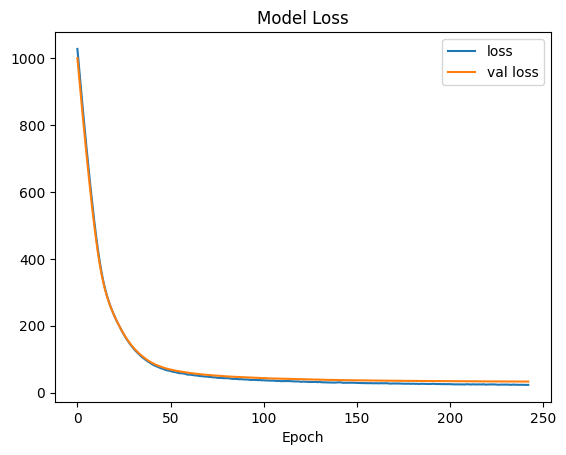

In [ ]:
# plot the history of the loss
start = 1
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss[start:], label="loss")
plt.plot(val_loss[start:], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()


In [ ]:
# test data
predictions = model.predict(X_test)
mse = np.mean((predictions - y_test)**2)
mae = np.mean(np.abs(predictions - y_test))
print("mse:", mse, "mae:", mae)

12/12 [==============================] - 2s 24ms/step
mse: 991.0075 mae: 20.640663


In [ ]:
# unaugmented test data
predictions = model.predict(X_test_noaug)
mse = np.mean((predictions - y_test_noaug)**2)
mae = np.mean(np.abs(predictions - y_test_noaug))
print("mse:", mse, "mae:", mae)


4/4 [==============================] - 0s 143ms/step
mse: 452.68396 mae: 15.145374


In [ ]:
# training
X = X_train
y = y_train
predictions = model.predict(X)
mse = np.mean((predictions - y)**2)
mae = np.mean(np.abs(predictions - y))
print("mse:", mse, "mae:", mae)

45/45 [==============================] - 1s 19ms/step
mse: 336.9126 mae: 10.133996


In [ ]:
bm.trainable = True
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 28224)             0         
                                                                 
 dropout_4 (Dropout)         (None, 28224)             0         
                                                                 
 dense_4 (Dense)             (None, 12)                338700    
                                                                 
Total params: 1277820 (4.87 MB)
Trainable params: 1265708 (4.83 MB)
Non-trainable params: 12112 (47.31 KB)
__________________

In [ ]:
# save weights
from google.colab import files
filename = 'MobileNetV3Small_all.h5'
model.save_weights(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>